<a href="https://colab.research.google.com/github/nail1021734/stock_example/blob/main/stock_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# 安裝套件
!pip install yfinance
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
# 從yahoo股市蒐集資料
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yf
yf.pdr_override()

# 指定公司
stock_name = '2330.TW'
# 指定訓練資料日期範圍 (從20200101開始至今)
start_date = datetime(2020, 1, 1)
end_date = None

# 透過api從yahoo股市下載指定公司資料
data = pdr.get_data_yahoo(stock_name, start=start_date, end=end_date).reset_index()
data.set_index('Date', inplace=True)

# 在colab界面輸出資料
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,332.5,339.0,332.5,339.0,313.791626,31754120
2020-01-03,344.0,345.0,335.5,339.5,314.254486,41811268
2020-01-06,333.0,334.5,332.0,332.0,307.312225,45343057
2020-01-07,332.5,333.0,326.5,329.5,304.998047,50879181
2020-01-08,325.0,333.0,325.0,329.5,304.998047,37567748
...,...,...,...,...,...,...
2023-06-15,590.0,593.0,587.0,591.0,591.000000,27392154
2023-06-16,590.0,590.0,584.0,589.0,589.000000,38128802
2023-06-19,583.0,585.0,582.0,583.0,583.000000,14346885


<Axes: xlabel='Date'>

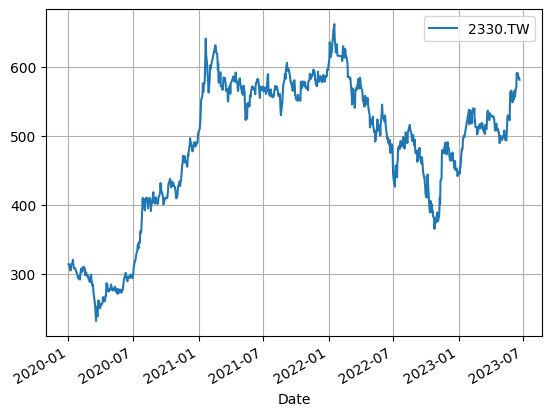

In [13]:
# 在圖表上呈現調整收盤假與日期的變化
data['Adj Close'].plot(label=stock_name, grid=True, legend=True)

In [14]:
# 準備訓練模型資料 (用前一天的開盤, 最高, 最低, 收盤, 調整收盤假, 成交量來預測明日的調整收盤假)
x = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']][:-1].to_numpy()
y = data['Adj Close'][1:].to_numpy()

# 切分資料(75%用於訓練, 25%用於測試)
split_ratio = 0.75

# 分割資料 (分割時照日期新舊排序, 最新的25％會做為測試資料)
x_train = x[:int(split_ratio*len(x))]
y_train = y[:int(split_ratio*len(x))].reshape(-1, 1)
x_test = x[int(split_ratio*len(x)):]
y_test = y[int(split_ratio*len(x)):].reshape(-1, 1)

In [15]:
from sklearn.linear_model import LinearRegression
# 建立模型
model = LinearRegression()
# 訓練模型
model = model.fit(x_train, y_train)

In [21]:
# 計算訓練完的模型於訓練資料的 Mean squared error
train_x_pred = model.predict(x_train)
train_mse = (train_x_pred - y_train).T@(train_x_pred - y_train) / y_train.shape[0]
print("訓練資料MSE:", train_mse[0][0])
# 計算訓練完的模型於訓練資料的 Mean squared error
test_x_pred = model.predict(x_test)
test_mse = (test_x_pred - y_test).T@(test_x_pred - y_test) / y_test.shape[0]
print("測試資料MSE:", test_mse[0][0])

訓練資料MSE: 6.473227134853245e+19
測試資料MSE: 6.920482686276235e+19


日期區間 2022-08-08 00:00:00 ~ 2023-06-21 00:00:00


<Axes: xlabel='Date'>

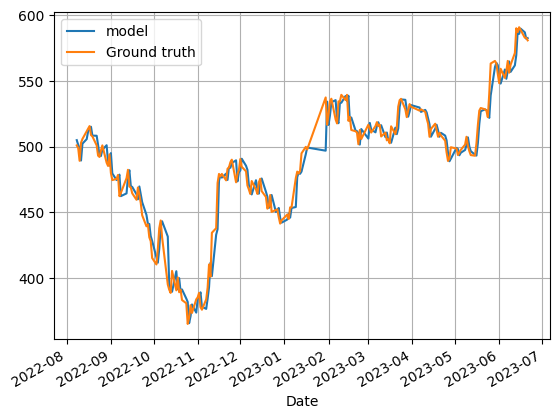

In [17]:
import pandas as pd

# 於測試資料上的圖表比較
predict_test = model.predict(x_test)
df = pd.DataFrame(predict_test, columns=['model'], index=data.index[1:][int(len(x)*split_ratio):])
df['Ground truth'] = y_test
print('日期區間', list(data.index[1:][int(len(x)*split_ratio):])[0], "~", list(data.index[1:][int(len(x)*split_ratio):])[-1])

df.plot(grid=True, legend=True)
# 此模型進行預測時需要前一天的[開盤, 最高, 最低, 收盤, 調整收盤假, 成交量]等特徵，因此沒辦法預測**後天**的調整收盤假，
# 除非能夠預測未來的[開盤, 最高, 最低, 收盤, 調整收盤假, 成交量]等特徵或是只使用前一天的調整收盤假當作輸入特徵，否則此模型只能根據前一天的資訊預測明天的收盤調整假

In [18]:
import numpy as np
print(data)
# 輸入資料 (Open, High, Low, Close, Adj Close, Volume) 以下範例為 20230621 用來預測 20230622
infr_x = np.array([582, 585, 578, 581, 581, 21703937] / x_train.sum(axis=0)).reshape(1, -1)

# 模型預測隔天調整收盤假
pred = model.predict(infr_x)
print("預測隔天收盤假:", pred)

             Open   High    Low  Close   Adj Close    Volume
Date                                                        
2020-01-02  332.5  339.0  332.5  339.0  313.791626  31754120
2020-01-03  344.0  345.0  335.5  339.5  314.254486  41811268
2020-01-06  333.0  334.5  332.0  332.0  307.312225  45343057
2020-01-07  332.5  333.0  326.5  329.5  304.998047  50879181
2020-01-08  325.0  333.0  325.0  329.5  304.998047  37567748
...           ...    ...    ...    ...         ...       ...
2023-06-15  590.0  593.0  587.0  591.0  591.000000  27392154
2023-06-16  590.0  590.0  584.0  589.0  589.000000  38128802
2023-06-19  583.0  585.0  582.0  583.0  583.000000  14346885
2023-06-20  579.0  585.0  579.0  583.0  583.000000  16221413
2023-06-21  582.0  585.0  578.0  581.0  581.000000  21703937

[842 rows x 6 columns]
預測隔天收盤假: [[2.77142734]]


In [19]:
# 嘗試其他模型
from sklearn.neural_network import MLPRegressor

# 使用多層 linear layer 的模型，看效果會不會比較好
model = MLPRegressor(hidden_layer_sizes=(100, 100, 100), solver="adam", verbose=True, learning_rate_init=5e-3, n_iter_no_change=1000, random_state=42, max_iter=500)

# 訓練時對輸入做簡單的 normalize 讓模型比較好訓練
model.fit(x_train / x_train.sum(axis=0), y_train)

# 計算訓練完的模型於訓練資料的 Mean squared error
train_x_pred = model.predict(x_train / x_train.sum(axis=0))
train_mse = (train_x_pred - y_train).T@(train_x_pred - y_train) / y_train.shape[0]
print("訓練資料MSE:", train_mse[0][0])
# 計算訓練完的模型於訓練資料的 Mean squared error
test_x_pred = model.predict(x_test / x_test.sum(axis=0))
test_mse = (test_x_pred - y_test).T@(test_x_pred - y_test) / y_test.shape[0]
print("測試資料MSE:", test_mse[0][0])

Iteration 1, loss = 122461.46268541
Iteration 2, loss = 121512.64566117
Iteration 3, loss = 119648.88155532
Iteration 4, loss = 116164.70657105
Iteration 5, loss = 110099.96826642


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 6, loss = 100448.00061438
Iteration 7, loss = 85691.63935750
Iteration 8, loss = 65432.97711860
Iteration 9, loss = 41001.26160760
Iteration 10, loss = 17815.16721541
Iteration 11, loss = 6852.27557987
Iteration 12, loss = 12636.11468426
Iteration 13, loss = 12668.15490548
Iteration 14, loss = 7733.53696770
Iteration 15, loss = 7101.17852621
Iteration 16, loss = 8134.06129566
Iteration 17, loss = 7713.19287705
Iteration 18, loss = 6740.55023600
Iteration 19, loss = 6661.45847043
Iteration 20, loss = 6892.73883545
Iteration 21, loss = 6729.75662791
Iteration 22, loss = 6573.27674753
Iteration 23, loss = 6611.20702187
Iteration 24, loss = 6605.87472343
Iteration 25, loss = 6568.43832710
Iteration 26, loss = 6559.38800486
Iteration 27, loss = 6555.17836960
Iteration 28, loss = 6553.93606698
Iteration 29, loss = 6543.90803332
Iteration 30, loss = 6547.42702754
Iteration 31, loss = 6550.39149511
Iteration 32, loss = 6567.24884225
Iteration 33, loss = 6542.44558428
Iteration 34, lo

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


日期區間 2022-08-08 00:00:00 ~ 2023-06-21 00:00:00


<Axes: xlabel='Date'>

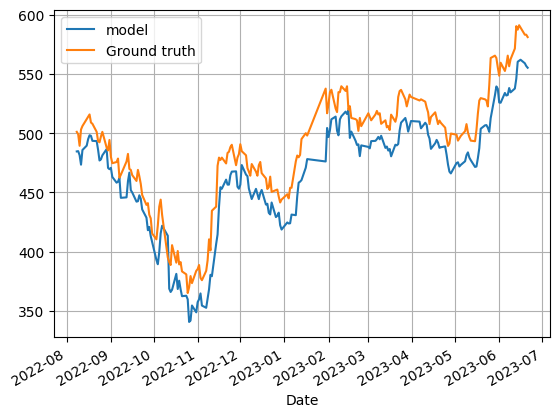

In [23]:
import pandas as pd

# 於測試資料上的圖表比較
predict_test = model.predict(x_test / x_train.sum(axis=0))
df = pd.DataFrame(predict_test, columns=['model'], index=data.index[1:][int(len(x)*split_ratio):])
df['Ground truth'] = y_test
print('日期區間', list(data.index[1:][int(len(x)*split_ratio):])[0], "~", list(data.index[1:][int(len(x)*split_ratio):])[-1])

df.plot(grid=True, legend=True)
# 雖然第二個模型可以學非線性的函數，但看起來第一個模型效果比較好
# 可能是非線性模型用梯度下降訓練，不容易找到最佳解的關係